# Rusty Bargain Car Sales Prediction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. Rusty Bargain is interested in the quality of the prediction; the speed of the prediction; and the time required for training. 

# Table of Contents
* [1. Data Preparation](#project_description)
* [2. Feature Engineering](#feature_engineering)
* [3. Model Training](#model_training)
    * [3.1 Building the Model](#Building_Model)
    * [3.2 Decision Tree](#Decision_Tree)
    * [3.3. Linear Regression](#Linear_Regression)
    * [3.4. Random Forest](#Random_Forest)
    * [3.5 Light GBM Regressor](#light_gbm_regressor)
    * [3.6 Catboost Regressor](#xgb_regressor)
    * [3.7 XGB Regressor](#xgb_regressor)
* [4. Summary of Models](#summary_models)
* [5. Feature Importances](#feature_importances)
* [6. Conclusions](#conclusions)

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import tree

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, roc_auc_score

import xgboost as XGBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [68]:
try:
    df = pd.read_csv('car_data.csv')

except:
    df = pd.read_csv('/datasets/car_data.csv')

In [69]:
df.shape

(354369, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [6]:
#Finding missing values and high cardinality
def missing_values (data):
    df = pd.DataFrame ()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        
        df = df.append(pd.DataFrame([col, len(unique_values), nans, zeros]).T, ignore_index=True)
        
    return df.rename(columns = {0: 'variable',
1: 'Unique Values',
2: 'Nan %',
3: 'Zeros %',
4: 'empty'}).sort_values('Nan %', ascending=False)

missing_values(df)

,variable,Unique Values,Nan %,Zeros %
11,NotRepaired,3,20.1,0.0
2,VehicleType,9,10.6,0.0
9,FuelType,8,9.3,0.0
4,Gearbox,3,5.6,0.0
6,Model,251,5.6,0.0
0,DateCrawled,15470,0.0,0.0
1,Price,3731,0.0,3.0
3,RegistrationYear,151,0.0,0.0
5,Power,712,0.0,11.4
7,Mileage,13,0.0,0.0


* Observations:
* NotRepaired has the highest number of missing values followed by VehicleType.
* DateCrawled has the highest number of cardinality, which means numerous categories.

In [7]:
df.duplicated().sum()

262

In [8]:
df.duplicated().sum()/df.shape[0]

0.0007393423239617461

In [9]:
#sample duplicates
df[df.duplicated()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
14266,21/03/2016 19:06,5999,small,2009,manual,80,polo,125000,5,petrol,volkswagen,no,21/03/2016 00:00,0,65529,05/04/2016 20:47
27568,23/03/2016 10:38,12200,bus,2011,manual,125,zafira,40000,10,gasoline,opel,no,23/03/2016 00:00,0,26629,05/04/2016 07:44
31599,03/04/2016 20:41,4950,wagon,2003,auto,170,e_klasse,150000,4,gasoline,mercedes_benz,no,03/04/2016 00:00,0,48432,05/04/2016 21:17
33138,07/03/2016 20:45,10900,convertible,2005,auto,163,clk,125000,5,petrol,mercedes_benz,no,07/03/2016 00:00,0,61200,21/03/2016 03:45
43656,13/03/2016 20:48,4200,sedan,2003,manual,105,golf,150000,10,gasoline,volkswagen,no,13/03/2016 00:00,0,14482,13/03/2016 20:48


In [10]:
#Descriptive Summary
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


* Observations:
* 1. Less than 10% are duplicated. 
* 2. There are outliers for Price, Registration Year, and Power. 
* 3. NumberofPictures column has no data. 

In [11]:
#fixing date and time
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(354107, 16)

In [14]:
#creating LastSeen column
df['DaysOnSite'] = (df['LastSeen'] - df['DateCreated']).dt.days

In [15]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysOnSite
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00,14
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00,14
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00,22
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,0
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00,6


In [16]:
#Creating Time Features from DateCreated
df['CreateYear'] = df['DateCreated'].dt.year
df['CreateMonth'] = df['DateCreated'].dt.month
df['CreateDay'] = df['DateCreated'].dt.day

In [17]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysOnSite,CreateYear,CreateMonth,CreateDay
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00,14,2016,3,24
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00,14,2016,3,24
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00,22,2016,3,14
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,0,2016,3,17
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00,6,2016,3,31


In [18]:
# Dealing with Missing Values
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
DaysOnSite               0
CreateYear               0
CreateMonth              0
CreateDay                0
dtype: int64

In [19]:
cat_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'NotRepaired']
for col in cat_cols:
    if df[col].dtype == 'object':
        df[col].fillna(('unknown'), inplace=True)

In [20]:
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
DaysOnSite           0
CreateYear           0
CreateMonth          0
CreateDay            0
dtype: int64

In [21]:
#dropping duplicates
df.drop_duplicates(inplace=True)

## Feature Engineering

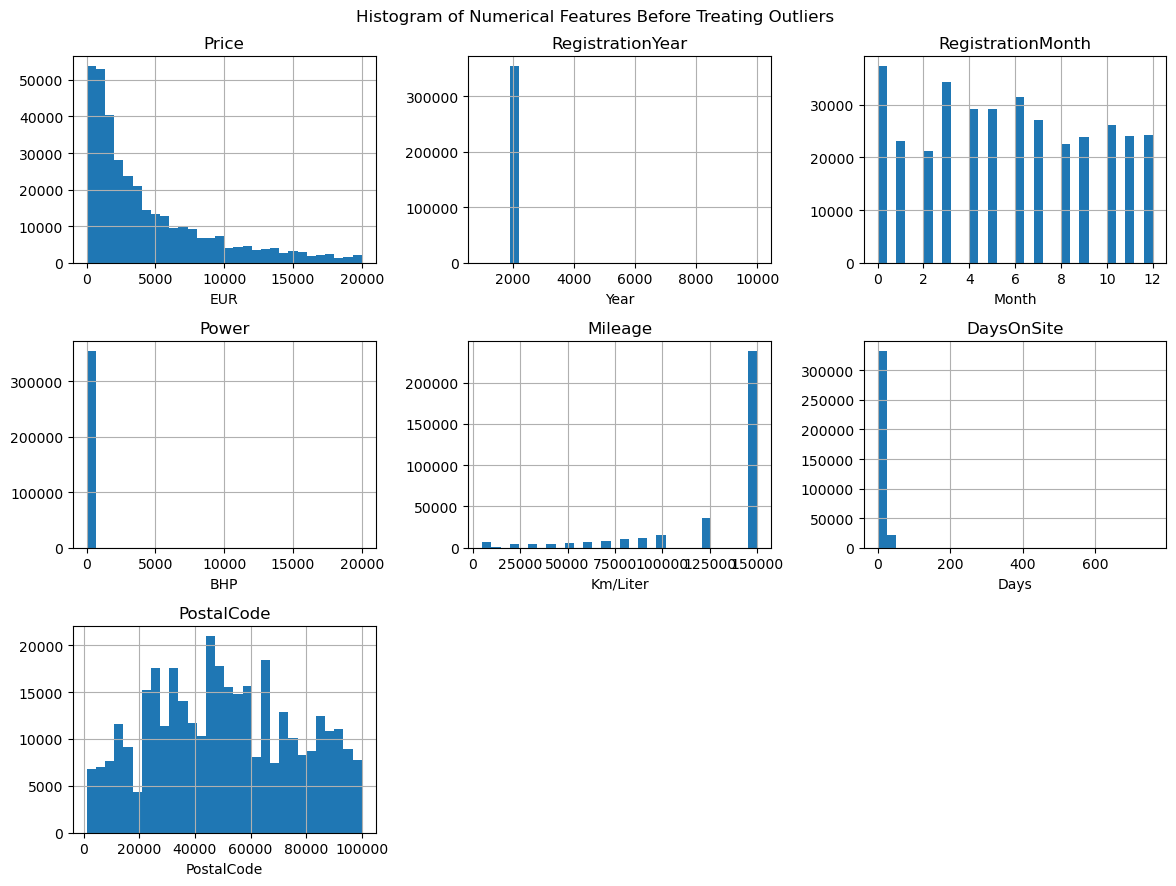

In [22]:
hist_cols = ['Price', 'RegistrationYear', 'RegistrationMonth', 'Power', 'Mileage', 'DaysOnSite', 'PostalCode']
xlabels = [['EUR', 'Year', 'Month'], ['BHP', 'Km/Liter', 'Days'], ['PostalCode']]
fig, ax = plt.subplots(figsize=(12,9))
axes = df[hist_cols].hist(bins=30, ax=ax)
for i in range(len(axes)):
    for j in range (len(axes)):
        if i == 2 and j > 0: continue
        axes[i][j].set_xlabel(xlabels[i][j])
plt.suptitle('Histogram of Numerical Features Before Treating Outliers')
plt.tight_layout()
plt.show()

* Observations:
* 1. Price is right-skewed which means prices of cars are in the lower range.
* 2. More cars were registered in the year 2000.

In [23]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode,DaysOnSite,CreateYear,CreateMonth,CreateDay
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030,8.679086,2015.999924,3.160149,15.860311
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094,8.640101,0.009049,0.376255,9.122859
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000,2014.000000,1.000000,1.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,2.000000,2016.000000,3.000000,8.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000,6.000000,2016.000000,3.000000,16.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,13.000000,2016.000000,3.000000,24.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,759.000000,2016.000000,12.000000,31.000000


In [24]:
#investigating the outliers
def identify_outliers(column, df):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df_outliers = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df_outliers

for col in ['Price', 'Power', 'Mileage', 'RegistrationYear']:
    df = identify_outliers(col, df)

In [25]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode,DaysOnSite,CreateYear,CreateMonth,CreateDay
count,268410.000000,268410.000000,268410.000000,268410.000000,268410.000000,268410.0,268410.000000,268410.000000,268410.000000,268410.000000,268410.000000
mean,3322.331582,2002.126784,103.313919,142599.325659,5.749573,0.0,50345.280239,8.361190,2015.999940,3.159234,15.855382
std,3178.512377,5.255548,55.539970,16203.817949,3.722813,0.0,25663.860035,8.529548,0.008189,0.373274,9.108237
min,0.000000,1989.000000,0.000000,90000.000000,0.000000,0.0,1067.000000,0.000000,2014.000000,1.000000,1.000000
25%,980.000000,1999.000000,69.000000,150000.000000,3.000000,0.0,30159.000000,2.000000,2016.000000,3.000000,8.000000
50%,2200.000000,2002.000000,105.000000,150000.000000,6.000000,0.0,49176.000000,6.000000,2016.000000,3.000000,16.000000
75%,4750.000000,2006.000000,140.000000,150000.000000,9.000000,0.0,70499.000000,13.000000,2016.000000,3.000000,24.000000
max,14400.000000,2016.000000,252.000000,150000.000000,12.000000,0.0,99998.000000,759.000000,2016.000000,12.000000,31.000000


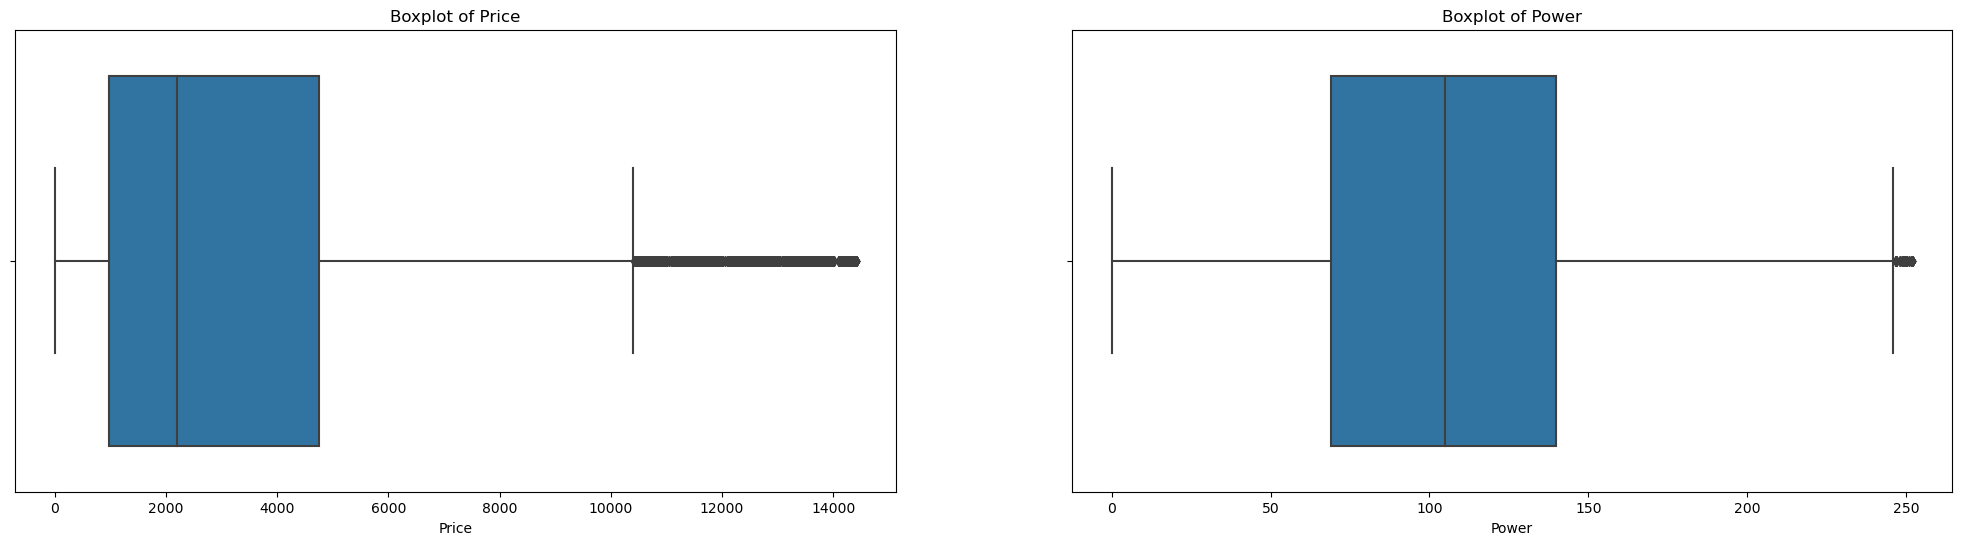

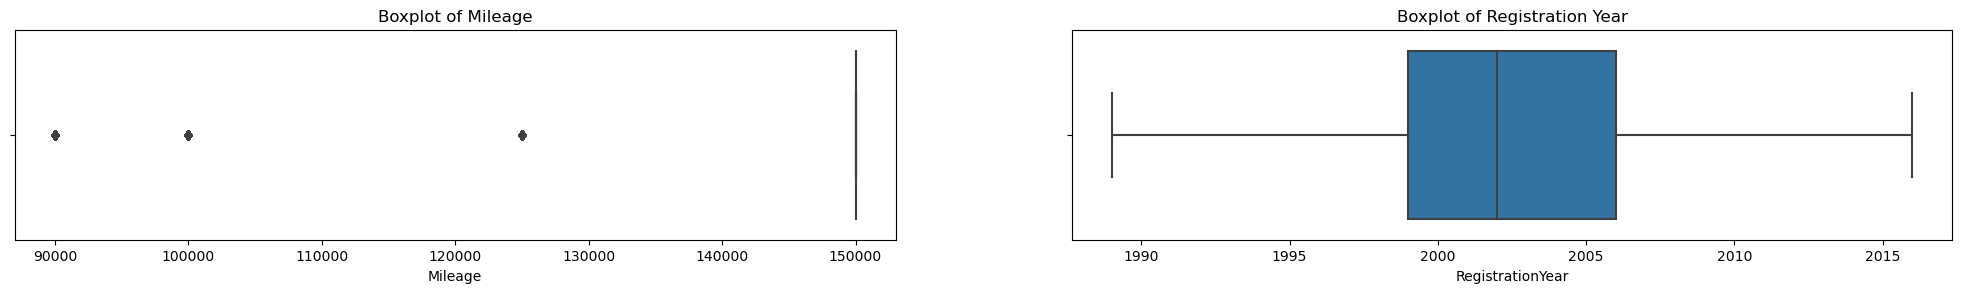

In [26]:
#Treating Outliers for columns Power, Price, Mileage, RegistrationYear
plt.figure(figsize=(25, 6))

plt.subplot(1,2,1)
plt.title('Boxplot of Price')
sns.boxplot(data=df, x='Price')

plt.subplot(1,2,2)
plt.title('Boxplot of Power')
sns.boxplot(data=df, x='Power')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(2,2,1)
plt.title('Boxplot of Mileage')
sns.boxplot(data=df, x='Mileage')

plt.subplot(2,2,2)
plt.title('Boxplot of Registration Year')
sns.boxplot(data=df, x='RegistrationYear')

plt.show()

In [27]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysOnSite,CreateYear,CreateMonth,CreateDay
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:00,14,2016,3,24
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00,22,2016,3,14
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,0,2016,3,17
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00,6,2016,3,31
5,2016-04-04 17:36:00,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:00,2,2016,4,4


In [28]:
#Dropping Columns not Needed for Model Training
drop_cols = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen']
df.drop(drop_cols, axis=1, inplace=True)

In [29]:
df.duplicated().sum()

5463

In [30]:
df.drop_duplicates(inplace=True)

In [31]:
df.duplicated().sum()

0

In [32]:
df.shape

(262947, 16)

In [33]:
df.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
DaysOnSite           0
CreateYear           0
CreateMonth          0
CreateDay            0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262947 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              262947 non-null  int64 
 1   VehicleType        262947 non-null  object
 2   RegistrationYear   262947 non-null  int64 
 3   Gearbox            262947 non-null  object
 4   Power              262947 non-null  int64 
 5   Model              262947 non-null  object
 6   Mileage            262947 non-null  int64 
 7   RegistrationMonth  262947 non-null  int64 
 8   FuelType           262947 non-null  object
 9   Brand              262947 non-null  object
 10  NotRepaired        262947 non-null  object
 11  PostalCode         262947 non-null  int64 
 12  DaysOnSite         262947 non-null  int64 
 13  CreateYear         262947 non-null  int64 
 14  CreateMonth        262947 non-null  int64 
 15  CreateDay          262947 non-null  int64 
dtypes: int64(10), object

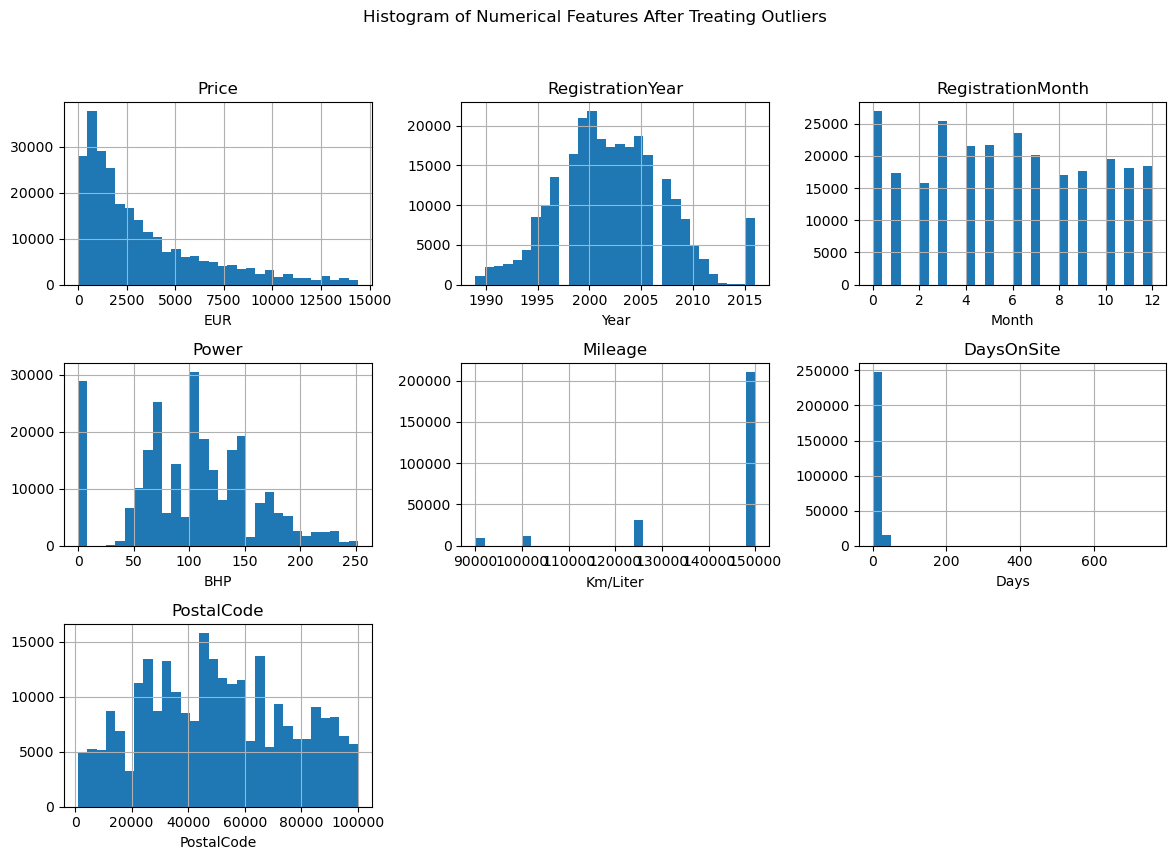

In [35]:
#Histogram after treating outliers
fig, ax = plt.subplots(figsize=(12,9))
axes = df[hist_cols].hist(bins=30, ax=ax)
for i in range(len(axes)):
    for j in range(len(axes)):
        if i == 2 and j > 0: continue
        axes[i][j].set_xlabel(xlabels[i][j])
plt.suptitle('Histogram of Numerical Features After Treating Outliers')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
#encoding Categorical Features  
encode_cols = ['PostalCode']
encode_cols += df.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder()
df[encode_cols] = oe.fit_transform(df[encode_cols])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262947 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              262947 non-null  int64  
 1   VehicleType        262947 non-null  float64
 2   RegistrationYear   262947 non-null  int64  
 3   Gearbox            262947 non-null  float64
 4   Power              262947 non-null  int64  
 5   Model              262947 non-null  float64
 6   Mileage            262947 non-null  int64  
 7   RegistrationMonth  262947 non-null  int64  
 8   FuelType           262947 non-null  float64
 9   Brand              262947 non-null  float64
 10  NotRepaired        262947 non-null  float64
 11  PostalCode         262947 non-null  float64
 12  DaysOnSite         262947 non-null  int64  
 13  CreateYear         262947 non-null  int64  
 14  CreateMonth        262947 non-null  int64  
 15  CreateDay          262947 non-null  int64  
dtypes:

In [38]:
def convert_dtype(df, field, dtype=np.uint8):
    try:
        df[field] = df[field].astype(dtype)
    except:
        print(f'Failed to change dtype for {field}')

In [39]:
dtype_cols = {
    'VehicleType': np.uint8,
    'RegistrationYear':np.uint16,
    'Gearbox':np.uint8,
    'Power':np.uint8,
    'Model':np.uint8,
    'RegistrationMonth':np.uint8,
    'FuelType':np.uint8,
    'Brand':np.uint8,
    'NotRepaired':np.uint8,
    'PostalCode':np.uint32,
    'DaysOnSite':np.uint16,
    'CreateYear':np.uint16,
    'CreateMonth':np.uint8,
    'CreateDay':np.uint8,
}

In [40]:
for col in dtype_cols:
    print(f'Conversion for {col}')
    convert_dtype(df, col, dtype_cols[col])

Conversion for VehicleType
Conversion for RegistrationYear
Conversion for Gearbox
Conversion for Power
Conversion for Model
Conversion for RegistrationMonth
Conversion for FuelType
Conversion for Brand
Conversion for NotRepaired
Conversion for PostalCode
Conversion for DaysOnSite
Conversion for CreateYear
Conversion for CreateMonth
Conversion for CreateDay


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262947 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              262947 non-null  int64 
 1   VehicleType        262947 non-null  uint8 
 2   RegistrationYear   262947 non-null  uint16
 3   Gearbox            262947 non-null  uint8 
 4   Power              262947 non-null  uint8 
 5   Model              262947 non-null  uint8 
 6   Mileage            262947 non-null  int64 
 7   RegistrationMonth  262947 non-null  uint8 
 8   FuelType           262947 non-null  uint8 
 9   Brand              262947 non-null  uint8 
 10  NotRepaired        262947 non-null  uint8 
 11  PostalCode         262947 non-null  uint32
 12  DaysOnSite         262947 non-null  uint16
 13  CreateYear         262947 non-null  uint16
 14  CreateMonth        262947 non-null  uint8 
 15  CreateDay          262947 non-null  uint8 
dtypes: int64(2), uint16(

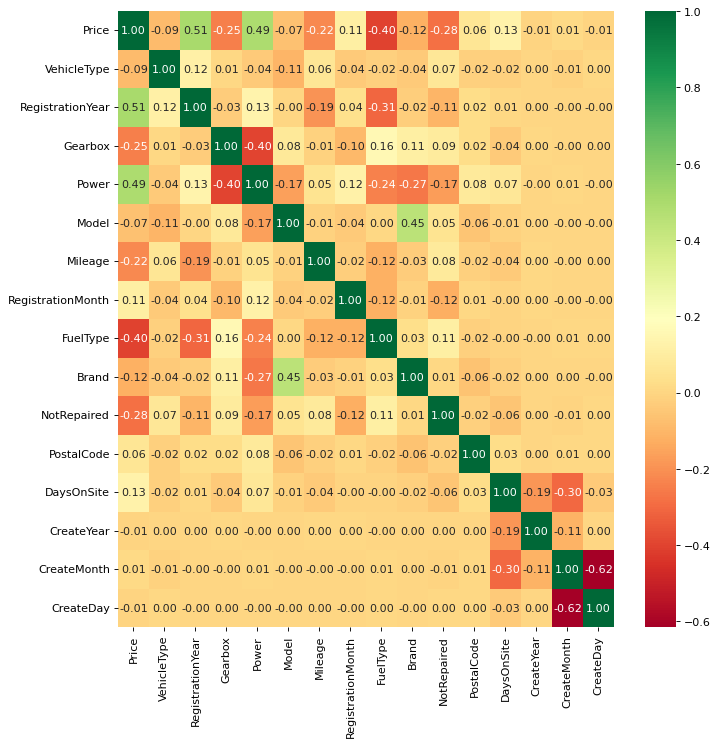

In [42]:
plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.show()

* Observations:
* 1. Price has a moderately strong positive correlation to Registration Year and Power. 
* 2. Mileage and Price are negatively correlated.
* 3. Brand and Model have a postiive correlation.

## Model training

In [43]:
#Splitting the Data
X = df.drop(['Price'], axis=1)
y = df['Price']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.1, random_state=42)

In [44]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape, valid_X.shape, valid_y.shape

((210357, 15), (5259, 15), (210357,), (5259,), (47331, 15), (47331,))

### Building the Model

In [45]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
def build_model (model, train_X, train_y, valid_X, valid_y,
                 hyperparameters={},
                 scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    
    np.random.seed(42)
    best_rmse=0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features = cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(valid_X)
    best_rmse = rmse(valid_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

### Decision Tree

In [47]:
dtf = tree.DecisionTreeClassifier(max_depth=3)
best_dtf_model, best_dtf_rmse, best_dtf_time = build_model(
    dtf, train_X, train_y, valid_X, valid_y, hyperparameters={},
    scoring=make_scorer(rmse), cv=5, model_str='dtf')

In [48]:
%%time
dtf.fit(train_X, train_y)
y_pred = dtf.predict(test_X)
dtf_rmse = mean_squared_error(test_y, y_pred)
print(f"RMSE Score (Decision Tree): {dtf_rmse:.2f}")

RMSE Score (Decision Tree): 5871097.36
CPU times: user 450 ms, sys: 11.8 ms, total: 462 ms
Wall time: 460 ms


### Linear Regression

In [49]:
lr_model = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(
    lr_model, train_X, train_y, valid_X, valid_y, hyperparameters={},
    scoring=make_scorer(rmse), cv=5, model_str='lr')

In [50]:
%%time
lr_model.fit(train_X, train_y)
y_pred = lr_model.predict(test_X)
lr_rmse = mean_squared_error(test_y, y_pred)
print(f"RMSE Score (Linear Regression) {lr_rmse:.2f}")

RMSE Score (Linear Regression) 4715191.81
CPU times: user 466 ms, sys: 16.1 ms, total: 482 ms
Wall time: 120 ms


### Random Forest

In [51]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=1234)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={},
                                                        scoring=make_scorer(rmse), cv=5, model_str='rf')

In [52]:
%%time
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
rf_rmse = mean_squared_error(test_y,y_pred)
print(f"RMSE Score (Random Forest): {rf_rmse:.2f}")

RMSE Score (Random Forest): 1769895.14
CPU times: user 1min 9s, sys: 99 ms, total: 1min 9s
Wall time: 9.33 s


### LightGBM 

In [53]:
lgb_model = LGBMRegressor(n_estimators=50, max_depth=15, random_state=234)
best_lgb_model, best_lgb_rmse, best_lgb_time = build_model(lgb_model, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={},
                                                        scoring=make_scorer(rmse), cv=5, model_str='lgb')

In [54]:
%%time
lgb_model.fit(train_X, train_y)
y_pred = lgb_model.predict(test_X)
lgb_rmse = mean_squared_error(test_y, y_pred)
print(f"RMSE Score (LGBM): {lgb_rmse:.2f}")

RMSE Score (LGBM): 1979447.07
CPU times: user 3.57 s, sys: 99.7 ms, total: 3.67 s
Wall time: 470 ms


### CatBoost Regressor

In [55]:
cat_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired', 'CreateYear', 'CreateMonth', 'CreateDay', 'PostalCode']
cat_model = CatBoostRegressor(learning_rate=0.9, loss_function='RMSE', random_seed=42)
best_cat_model, best_cat_rmse, best_cat_time = build_model(cat_model, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={'iterations': [20, 30, 40, 50]},
                                                        scoring=make_scorer(rmse), cv=5, model_str='catboost', cat_features=cat_features)

0:	learn: 1951.8497785	total: 78.7ms	remaining: 1.5s
1:	learn: 1754.1145539	total: 92.4ms	remaining: 832ms
2:	learn: 1674.8105450	total: 103ms	remaining: 582ms
3:	learn: 1618.4737779	total: 113ms	remaining: 452ms
4:	learn: 1579.5465991	total: 122ms	remaining: 366ms
5:	learn: 1532.7819762	total: 132ms	remaining: 308ms
6:	learn: 1501.0279063	total: 141ms	remaining: 262ms
7:	learn: 1483.5641611	total: 150ms	remaining: 225ms
8:	learn: 1466.9070693	total: 159ms	remaining: 194ms
9:	learn: 1451.5551446	total: 169ms	remaining: 169ms
10:	learn: 1438.8881918	total: 179ms	remaining: 146ms
11:	learn: 1427.7881957	total: 189ms	remaining: 126ms
12:	learn: 1416.3554544	total: 201ms	remaining: 108ms
13:	learn: 1408.1582624	total: 212ms	remaining: 90.8ms
14:	learn: 1404.9874660	total: 221ms	remaining: 73.7ms
15:	learn: 1399.0339798	total: 233ms	remaining: 58.3ms
16:	learn: 1390.9393092	total: 244ms	remaining: 43.1ms
17:	learn: 1386.8350827	total: 255ms	remaining: 28.3ms
18:	learn: 1380.6609419	total: 2

In [56]:
%%time
cat_model.fit(train_X, train_y, verbose=False)
y_pred = cat_model.predict(test_X)
cat_rmse = mean_squared_error(test_y, y_pred, squared=False)
print(f"RMSE Score (CatBoost): {cat_rmse:.2f}")

RMSE Score (CatBoost): 1279.38
CPU times: user 1min 22s, sys: 3.03 s, total: 1min 25s
Wall time: 12.4 s


### XGB Regressor

In [57]:
xgb_model = XGBoostRegressor.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=6)
best_xgb_model, best_xgb_rmse, best_xgb_time = build_model(xgb_model, train_X, train_y,
                                                        valid_X, valid_y,
                                                        hyperparameters={},
                                                        scoring=make_scorer(rmse), cv=5, model_str='xgb')

In [58]:
%%time
xgb_model.fit(train_X, train_y, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(test_X, test_y)], verbose=False)
y_pred = xgb_model.predict(test_X)
xgb_rmse = mean_squared_error(test_y, y_pred, squared=False)
print(f"RMSE Score (XGB): {xgb_rmse:.2f}")

RMSE Score (XGB): 1237.73
CPU times: user 4min 14s, sys: 4.51 s, total: 4min 18s
Wall time: 41 s


## Summary of Models

In [59]:
df_models = pd.DataFrame({'model': ['DTree', 'LRegression', 'RForest', 'LGBM', 'CatBoost', 'XGB'],
                         'RMSE': [best_dtf_rmse, best_lr_rmse, best_rf_rmse, best_lgb_rmse, best_cat_rmse, best_xgb_rmse],
                         'Train_Time': [best_dtf_time, best_lr_time, best_rf_time, best_lgb_time, best_cat_time, best_xgb_time]})

In [60]:
df_models

,model,RMSE,Train_Time
0,DTree,2375.761297,4.20
1,LRegression,2131.260688,1.49
2,RForest,1318.045807,59.85
3,LGBM,1371.088685,3.75
4,CatBoost,1363.284432,18.68
5,XGB,1228.778811,376.22


* Observations:
* All models were trained using GridSearch. The best performing model is **XGB which estimates the price of the car with 1228 EURO** but has the longest train time of 398.78 seconds. 
* In terms of train time, **Linear Regression has the least time with .69 second** but priced cars with 2131 EURO. 

## Feature Importances of Best Model

In [61]:
feature_imp = pd.DataFrame(best_xgb_model.feature_importances_, index=df.columns[1:].tolist()).sort_values(0, ascending=False).reset_index()
feature_imp.rename(columns={'index':'Features', 0:'Value'}, inplace=True)

In [62]:
feature_imp

,Features,Value
0,RegistrationYear,0.351506
1,Power,0.164442
2,NotRepaired,0.119234
3,Mileage,0.078731
4,Brand,0.075940
5,VehicleType,0.050981
6,FuelType,0.037981
7,CreateMonth,0.031361
8,Gearbox,0.027835
9,DaysOnSite,0.021998


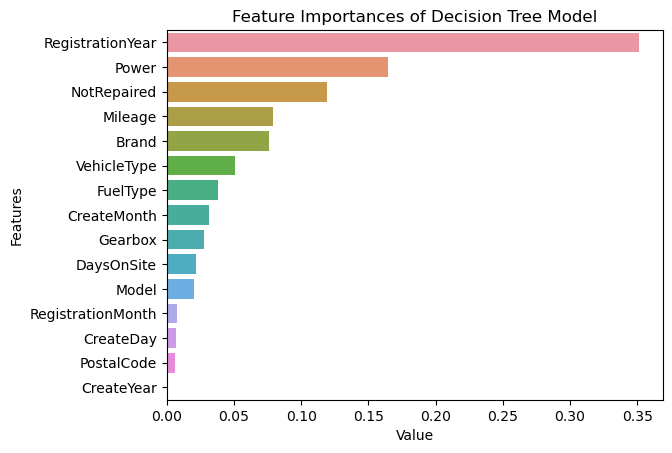

In [63]:
plt.title('Feature Importances of Decision Tree Model') 
sns.barplot(
    data=feature_imp.sort_values('Value', ascending=False),
    y='Features',
    x='Value',
    orient='h',
)

plt.show()

* Observations:
* The top 3 important features are: **Registration Year, Power, and Not Repaired.** 

## Model Analysis

In [64]:
def test_pred(model, test_X, test_y):
    start_time = time.time()
    preds = model.predict(test_X)
    return np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [65]:
models = [best_dtf_model, best_lr_model, best_rf_model, best_lgb_model, best_cat_model, best_xgb_model]
for model in models:
    pred_time, best_rmse = test_pred(model, test_X, test_y)
    print(f"The RMSE on the test set is: {best_rmse}, and time to predict {pred_time} seconds.")

The RMSE on the test set is: 2423.0347415613883, and time to predict 0.04100632667541504 seconds.
The RMSE on the test set is: 2171.449241868441, and time to predict 0.0067293643951416016 seconds.
The RMSE on the test set is: 1330.3740611581418, and time to predict 0.1735832691192627 seconds.
The RMSE on the test set is: 1406.928237495359, and time to predict 0.008916616439819336 seconds.
The RMSE on the test set is: 1377.5384209131655, and time to predict 0.043927907943725586 seconds.
The RMSE on the test set is: 1225.8095732515196, and time to predict 0.036592960357666016 seconds.


* Observations:
* When using the prediction time, Linear Regression is the fastest with 0.0005 seconds. 
* XGB has the least RMSE which has the predicted price of 1225 EURO.  

# Conclusions

This project aims to compare ML models in order to select an optimal model to determine the price of used cars of Rusty Bargain. The shop is developing an app to attract new customers. The app will find the best market value of used cars. Originally, the data has 354369 rows and 16 columns. VehicleType, Gearbox, Model, Fueltype, and NotRepaired are categorical columns that contains missing values. These columns are filled with 'unknown.' 

At the EDA processing, duplicates were dropped and outliers are treated using the IQR method. The most important columns are Price, VehicleType, Gearbox, Power, Model, Mileage, FuelType, Brand, and VehicleAge. The columns DateCrawled, DateCreated, NumberOfPicture, and LastSeen were dropped since they are insignificant to the business problem. After EDA, the new dataset has **262947 rows and 16 columns.** 80% was used to train the data, 2% for testing, and 18% for validity. The following were used as models along with hyperparameter tuning and gradient boosting: Decision Tree, Linear Regression, Random Forest, LightBGM, Catboost Regressor, and XGB Regressor. 

The RMSE, training time, and prediction time are determined in the machine learning modelling. Under training time, XGB estimates the car price at 1228 EURO being the cheapest at 376 seconds, while DecisionTree estimates the highest car price of 2375 EURO at 4 seconds. The RMSE scores at training time are not far off from each other but the training time are. 

After analyzing the models, Linear Regression outperformed with .007 seconds even though it estimates the car price at 2171 EURO. **Therefore, the car price should be at 2171 EURO.**